In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from textblob import Word

In [2]:
#Read DATA
data = pd.read_csv('data/data.csv')

In [3]:

#cleaning the dataste
#Removing Special characters, Digits, uneccasry symbols, and stop words
def cleaning(df,stop_words):
    df['answers'] = df['answers'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

    df['answers'] = df['answers'].str.replace('[0-9]+', '')

    df['answers'] = df['answers'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    df['answers'] = df['answers'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df
    
stopwords = stopwords.words('english')

data_a = cleaning(data, stopwords)

stopwords = set(STOPWORDS)

C:\Users\Zack\AppData\Local\Temp\ipykernel_11608\432826640.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['answers'] = df['answers'].str.replace('[0-9]+', '')


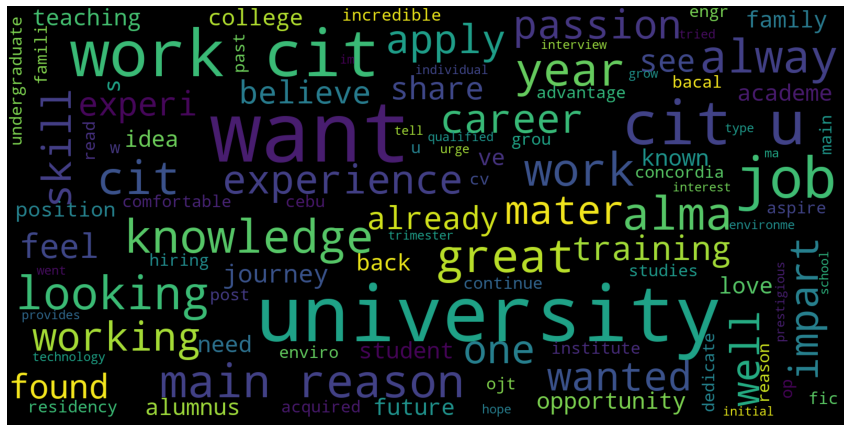

In [4]:
#Visualizing common words in the answers,
#size of each word represents its frequency of occurence in the data
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(data_a["answers"])

In [5]:
#Tokenizing and converting the answers into numerical vectors or 
#convert text into sequences so the network or model can deal with it as input
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['answers'].values)
X = tokenizer.texts_to_sequences(data['answers'].values)
X = pad_sequences(X)

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

64
42


In [6]:
#Graphing purpose, Visual representation of the learning
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    #plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [7]:
#Composing the LSTM network. Putting the Hyperparameters
#Using softmax as activation because Network used is 'Categorial Crossentropy'
embed_dim = 120
lstm_out = 176

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 120)           60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 74, 120)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#Here I declare splitting the data into training and test data set
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(37, 74) (37, 2)
(16, 74) (16, 2)


In [9]:
#Here we train the model using the batch size 5 for I only have few data with 5 epochs only
batch_size = 4
history = model.fit(X_train, Y_train, epochs =10, batch_size=batch_size, verbose = 2)

Epoch 1/10
10/10 - 3s - loss: 0.6863 - accuracy: 0.5946 - 3s/epoch - 251ms/step
Epoch 2/10
10/10 - 1s - loss: 0.6546 - accuracy: 0.5946 - 716ms/epoch - 72ms/step
Epoch 3/10
10/10 - 1s - loss: 0.5420 - accuracy: 0.7297 - 654ms/epoch - 65ms/step
Epoch 4/10
10/10 - 1s - loss: 0.7584 - accuracy: 0.6486 - 625ms/epoch - 63ms/step
Epoch 5/10
10/10 - 1s - loss: 0.3826 - accuracy: 0.7568 - 647ms/epoch - 65ms/step
Epoch 6/10
10/10 - 1s - loss: 0.3169 - accuracy: 0.8919 - 624ms/epoch - 62ms/step
Epoch 7/10
10/10 - 1s - loss: 0.2179 - accuracy: 0.9459 - 675ms/epoch - 68ms/step
Epoch 8/10
10/10 - 1s - loss: 0.1451 - accuracy: 0.9459 - 674ms/epoch - 67ms/step
Epoch 9/10
10/10 - 1s - loss: 0.0989 - accuracy: 1.0000 - 652ms/epoch - 65ms/step
Epoch 10/10
10/10 - 1s - loss: 0.0775 - accuracy: 0.9730 - 630ms/epoch - 63ms/step


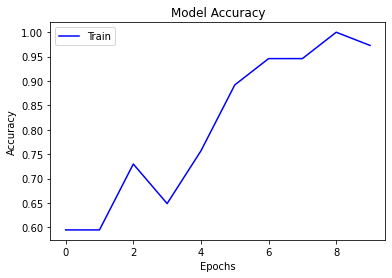

In [10]:
#visual representation of the model's accuracy after training
generate_graph(history)

In [11]:
#Extraction of validation set, measuring score and accuracy
validation_size = 11

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 6)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

1/1 - 0s - loss: 1.8264 - accuracy: 0.6000 - 230ms/epoch - 230ms/step
score: 1.83
acc: 0.60


In [12]:
#In here I measured the number of correct guesses
#Based on the results we can clearly see the positive prediction is way more higher than the negative this maybe due to lack of data
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 173ms/epoch - 173ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
pos_acc 87.5 %
neg_acc 66.66666666666666 %


In [29]:
#here I test on the results
answer = ["I am looking for a job that can develop my guidance and counseling experiences. I am inspired by my friend that is trustworthy. I am planning to enroll in Masteral for Guidance and Counseling Psychology."]
#vectorizing answers by the pre-fitted tokenizer instance
sequenced = tokenizer.texts_to_sequences(answer)
#padding the answers to have exactly the same shape as `embedding_2` input
padded = pad_sequences(sequenced, maxlen=74, dtype='int32', value=0)
sentiment = model.predict(padded,batch_size=1,verbose = 2)[0]

def results(sentiment):
    eval = 0
    if (np.argmax(sentiment) == 1):
        eval = 1
    return eval
#Function of prediction
if (results(sentiment)== 1):
    print("Hired")
else:
    print("Not-Hired")



1/1 - 0s - 20ms/epoch - 20ms/step
Not-Hired


In [14]:
#Saving the model
#model.save("SA_LSTM_V1.h5")
#del model